In [1]:
# imports
import torch
import torch.nn as nn
import librosa
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
import typing

In [2]:
cuda_available = torch.cuda.is_available()

device = torch.device("cuda" if cuda_available else "cpu")

print(f"Device: {device}")

Device: cuda


In [ ]:
import torch
import torch.nn as nn
import math
from torch.utils.data import DataLoader, Dataset
from contextlib import nullcontext


class Pedal(nn.Module):
    # determine how many channels our audio data represents. 1 for mono 2 for stereo
    # should be the same for input and output
    INPUT_OUTPUT_SIZE = 1

    def __init__(
        self,
        hidden_size,
        window_size,
        normalization_data,
        init_len=200,
        num_layers=1,
        hidden=None,
    ):
        super(Pedal, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.window_size = window_size
        self.init_len = init_len

        self.lstm = nn.LSTM(
            Pedal.INPUT_OUTPUT_SIZE, hidden_size, self.num_layers, dropout=0.2
        )
        self.last_layer = nn.Linear(hidden_size, Pedal.INPUT_OUTPUT_SIZE, bias=True)
        self.hidden = hidden

        self.normalization_data = normalization_data

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, self.hidden = self.lstm(x, self.hidden)
        output = self.last_layer(output)

        return output + x

    def train_epoch(
        self,
        data_loader: DataLoader,
        criterion: nn.Module,
        optimizer: torch.optim.Optimizer,
    ) -> float:
        batch_loss = 0.0
        for inputs, targets in data_loader:
            # populate hidden layer with information using some early data
            init_inputs = inputs[0 : self.init_len :, :, :]
            rest_inputs = inputs[self.init_len :, :, :]
            rest_targets = targets[self.init_len :, :, :]

            self(init_inputs)

            window_start_idx = self.init_len
            window_loss = 0

            # so that we don't have zero range
            window_iterations = (
                len(rest_inputs) // self.window_size
                if len(rest_inputs) % self.window_size == 0
                else 1
            )
            for _ in range(window_iterations):
                window_inputs = rest_inputs[
                    window_start_idx : window_start_idx + self.window_size, :, :
                ]
                window_targets = rest_targets[
                    window_start_idx : window_start_idx + self.window_size, :, :
                ]

                outputs = self(window_inputs)
                loss = criterion(outputs, window_targets)

                loss.backward()
                optimizer.step()

                # prepare for next batch
                # save hidden state for next batch
                self.detach_hidden()
                self.zero_grad()
                window_loss += loss
                window_start_idx += self.window_size

            batch_loss += (
                window_loss / window_iterations if window_iterations > 0 else 0
            )
            self.reset_hidden()

        return batch_loss / len(data_loader)

    def train(
        self,
        data_loader: DataLoader,
        criterion: nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler.ReduceLROnPlateau,
        num_epochs: int,
    ) -> float:
        lowest_loss = float("inf")
        for epoch in range(num_epochs):
            loss = self.train_epoch(data_loader, criterion, optimizer)
            scheduler.step(loss)
            print(f"Epoch: {epoch + 1}, Loss: {loss}")

            lowest_loss = min(lowest_loss, loss)

        print(f"Lowest Loss: {lowest_loss} reached after {num_epochs} epochs.")
        return lowest_loss

    def noramlize_data(self, data: torch.Tensor) -> torch.Tensor:
        return (data - self.normalization_data["min"]) / (
            self.normalization_data["max"] - self.normalization_data["min"]
        )

    # detach hidden state, this resets gradient tracking on the hidden state
    def detach_hidden(self):
        if self.hidden.__class__ == tuple:
            self.hidden = tuple([h.clone().detach() for h in self.hidden])
        else:
            self.hidden = self.hidden.clone().detach()

    # changes the hidden state to None, causing pytorch to create an all-zero hidden state when the rec unit is called
    def reset_hidden(self):
        self.hidden = None

    def save_model(self, path: str) -> None:
        torch.save(self.state_dict(), path)
        print("Model saved successfully.")

    def load_model(self, path: str) -> None:
        self.load_state_dict(torch.load(path))

    def predict(self, x: torch.Tensor, normalize=False) -> torch.Tensor:
        model.eval()

        if normalize:
            x = self.noramlize_data(x)

        # Reshape input tensor to LSTM input shape
        x = x.unsqueeze(1)

        with torch.no_grad():
            return self(x)

    def validate(self, input_data, target_data, loss_fcn, chunk, grad=False):
        with torch.no_grad() if not grad else nullcontext():
            output = torch.empty_like(target_data)
            for l in range(int(output.size()[0] / chunk)):
                output[l * chunk : (l + 1) * chunk] = self(
                    input_data[l * chunk : (l + 1) * chunk]
                )
                self.detach_hidden()
            # If the data set doesn't divide evenly into the chunk length, process the remainder
            if not (output.size()[0] / chunk).is_integer():
                output[(l + 1) * chunk : -1] = self(input_data[(l + 1) * chunk : -1])
            self.reset_hidden()
            loss = loss_fcn(output, target_data)
        return output, loss

In [9]:
import soundfile as sf

def save_audio_file(input_signal: torch.Tensor, new_sampling_rate: int, path: str) -> None:
    output_signal = input_signal
    sf.write(path, output_signal, new_sampling_rate)

def to_tensor(data: np.ndarray) -> torch.Tensor:
    return torch.tensor(data, dtype=torch.float32).unsqueeze(1)

def load_audio(file_path: str) -> tuple:
    audio_signal, sampling_rate = librosa.load(file_path, sr=None)
    return audio_signal, sampling_rate

def plot_waveform(wave: np.ndarray) -> None:
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(wave)
    plt.title("Waveform")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

In [24]:
num_classes = 1
input_size = num_classes
output_size = input_size
batch_size = 128
init_len = 200
up_fr = 1000
hidden_size = 96
num_layers = 1
num_epochs = 15
learning_rate = 0.005
reload_model = False

lstm_model = SimpleLSTM(input_size, output_size, hidden_size, num_layers, hidden=(torch.zeros(num_layers, 1, hidden_size).to(device), torch.zeros(num_layers, 1, hidden_size).to(device)))

lstm_model.load_model("lstm_guitar_model.pth")
# Predict
# test_audio_signal, test_sampling_rate = load_audio("./data/ML_Pedal_Input_DS.wav")
# target_audio_signal, target_sampling_rate = load_audio("./data/ML_Pedal_Output_DS.wav")
test_audio_signal, test_sampling_rate = load_audio('./data/ML_Pedal_Input_DS.wav')
target_audio_signal, target_sampling_rate = load_audio('./data/ML_Pedal_Output_DS.wav')

test_audio_signal = test_audio_signal[:test_sampling_rate * 60]
target_audio_signal = target_audio_signal[:target_sampling_rate * 60]

lstm_model.eval()
test_audio_signal_tensor = to_tensor(test_audio_signal).to("cpu")

lstm_model.to("cpu")
lstm_model.hidden = lstm_model.hidden[0].to("cpu"), lstm_model.hidden[1].to("cpu")

predicted_audio_signal = lstm_model.predict(test_audio_signal_tensor)

numpy_audio_signal = predicted_audio_signal.cpu().numpy().flatten()

print(f"Predicted Audio Signal Shape: {numpy_audio_signal.shape}")
print(f"Actual Audio Signal Shape: {target_audio_signal.shape}")

save_audio_file(numpy_audio_signal, test_sampling_rate, "predicted_audio.wav")

/home/sum/Documents/school/cs363m/guitar-pedal-ml/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/tmp/ipykernel_1118064/755014950.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

Predicted Audio Signal Shape: (960000,)
Actual Audio Signal Shape: (960000,)


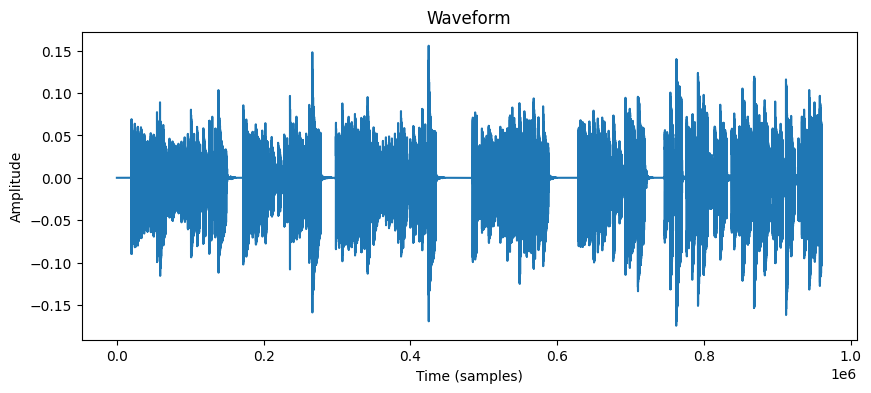

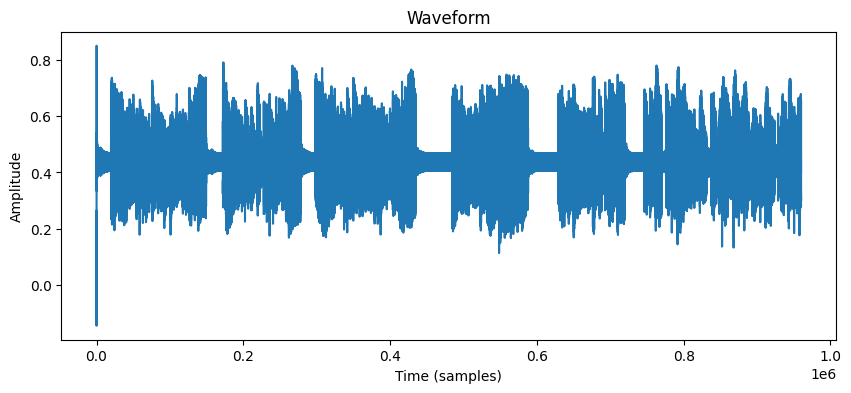

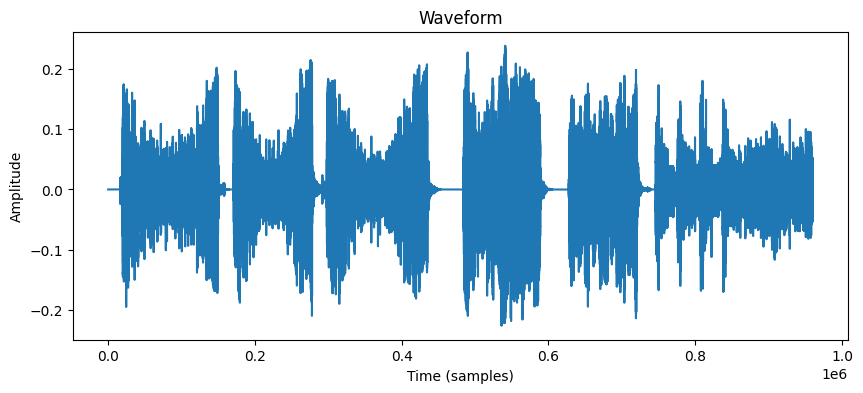

In [25]:
# Plot the predicted audio signal
plot_waveform(test_audio_signal)
plot_waveform(numpy_audio_signal)
plot_waveform(target_audio_signal)